<a href="https://colab.research.google.com/github/kairamilanifitria/Text-Classification-drug-/blob/main/Drug_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import csv

In [6]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [7]:
data1 = pd.read_csv("/content/drive/MyDrive/research/drugsComTrain_raw.tsv",sep = '\t', quoting=csv.QUOTE_NONE, encoding='utf-8')

In [8]:
data2 = pd.read_csv("/content/drive/MyDrive/research/drugsComTest_raw.tsv",sep = '\t', quoting=csv.QUOTE_NONE, encoding='utf-8')

In [9]:
data = pd.concat([data1,data2])[['review','condition']]
data.head()

,review,condition
0,"""""""It has no side effect, I take it in combina...",Left Ventricular Dysfunction
1,"""""""My son is halfway through his fourth week o...",ADHD
2,192,"April 27, 2010"
3,"""""""I used to take another oral contraceptive, ...",Birth Control
4,17,"December 14, 2009"


In [10]:
# remove NULL Values from data
data = data[pd.notnull(data['review'])]

finding the max length

In [11]:
data['len'] = data['review'].apply(lambda s : len(s))

<Axes: ylabel='Frequency'>

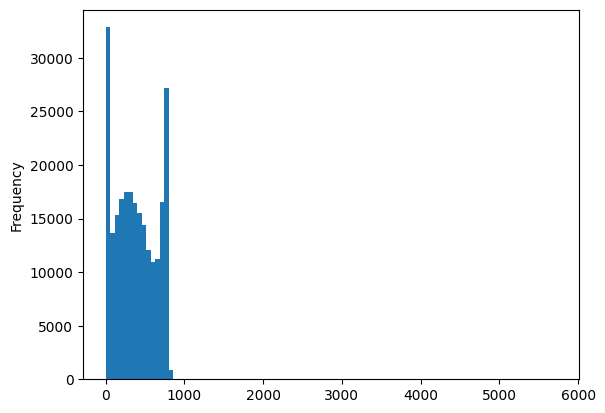

In [12]:
data['len'].plot.hist(bins=100)

In [13]:
data.len.quantile(0.9)

753.0

Preprocessing Y Column

In [14]:
count_df = data[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
count_df.head()

,condition,review
686,Birth Control,38436
1022,Depression,12164
3322,Pain,8245
136,Anxiety,7812
90,Acne,7435


In [15]:
target_conditions = count_df[count_df['review']>3000]['condition'].values

In [16]:
def condition_parser(x):
    if x in target_conditions:
        return x
    else:
        return "OTHER"

data['condition'] = data['condition'].apply(lambda x: condition_parser(x))

In [17]:
data = data[data['condition']!='OTHER']

In [18]:
import plotly.express as px
px.bar(count_df[count_df['review']>3000],x='condition',y='review')


In [19]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [20]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [21]:
# lower the text
data["review"] = data["review"].apply(lambda x: x.lower())

# Clean the text
data["review"] = data["review"].apply(lambda x: clean_text(x))

# Clean numbers
data["review"] = data["review"].apply(lambda x: clean_numbers(x))

# Clean Contractions
data["review"] = data["review"].apply(lambda x: replace_contractions(x))

In [22]:
data['condition'].unique()

array(['ADHD', 'Birth Control', 'Emergency Contraception',
       'Bipolar Disorde', 'Depression', 'Obesity', 'Insomnia',
       'Vaginal Yeast Infection', 'Pain', 'Diabetes, Type 2', 'Anxiety',
       'Acne', 'High Blood Pressure', 'Weight Loss'], dtype=object)

In [23]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['review'], data['condition'], stratify=data['condition'], test_size=0.25)

In [24]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (83673,)
Test shape :  (27891,)


In [25]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [27]:
le.classes_

array(['ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde', 'Birth Control',
       'Depression', 'Diabetes, Type 2', 'Emergency Contraception',
       'High Blood Pressure', 'Insomnia', 'Obesity', 'Pain',
       'Vaginal Yeast Infection', 'Weight Loss'], dtype=object)

Load Embeddings

In [30]:
import numpy as np

def load_glove(word_index):
    EMBEDDING_FILE = '/content/drive/MyDrive/research/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(list(embeddings_index.values()))  # Convert to list here
    emb_mean, emb_std = -0.005838499, 0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix


In [31]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

In [32]:
np.shape(embedding_matrix)

(28713, 300)

Pytorch Model - TextCNN

In [33]:
class CNN_Text(nn.Module):

    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc1(x)
        return logit

Train TextCNN Model

In [34]:
n_epochs = 6
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)

    # Set model to validation configuration -Doesn't get trained here
    model.eval()
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()

    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<ipython-input-34-dc94669eaebe>:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/6 	 loss=512.1861 	 val_loss=258.4247  	 val_acc=0.8326  	 time=41.43s
Epoch 2/6 	 loss=248.6187 	 val_loss=222.0146  	 val_acc=0.8522  	 time=42.57s
Epoch 3/6 	 loss=217.3187 	 val_loss=203.5745  	 val_acc=0.8636  	 time=45.03s
Epoch 4/6 	 loss=197.5930 	 val_loss=193.6564  	 val_acc=0.8687  	 time=44.01s
Epoch 5/6 	 loss=183.6054 	 val_loss=187.8122  	 val_acc=0.8720  	 time=44.54s
Epoch 6/6 	 loss=170.4376 	 val_loss=180.6587  	 val_acc=0.8763  	 time=44.23s


In [35]:
torch.save(model,'textcnn_model')

In [36]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

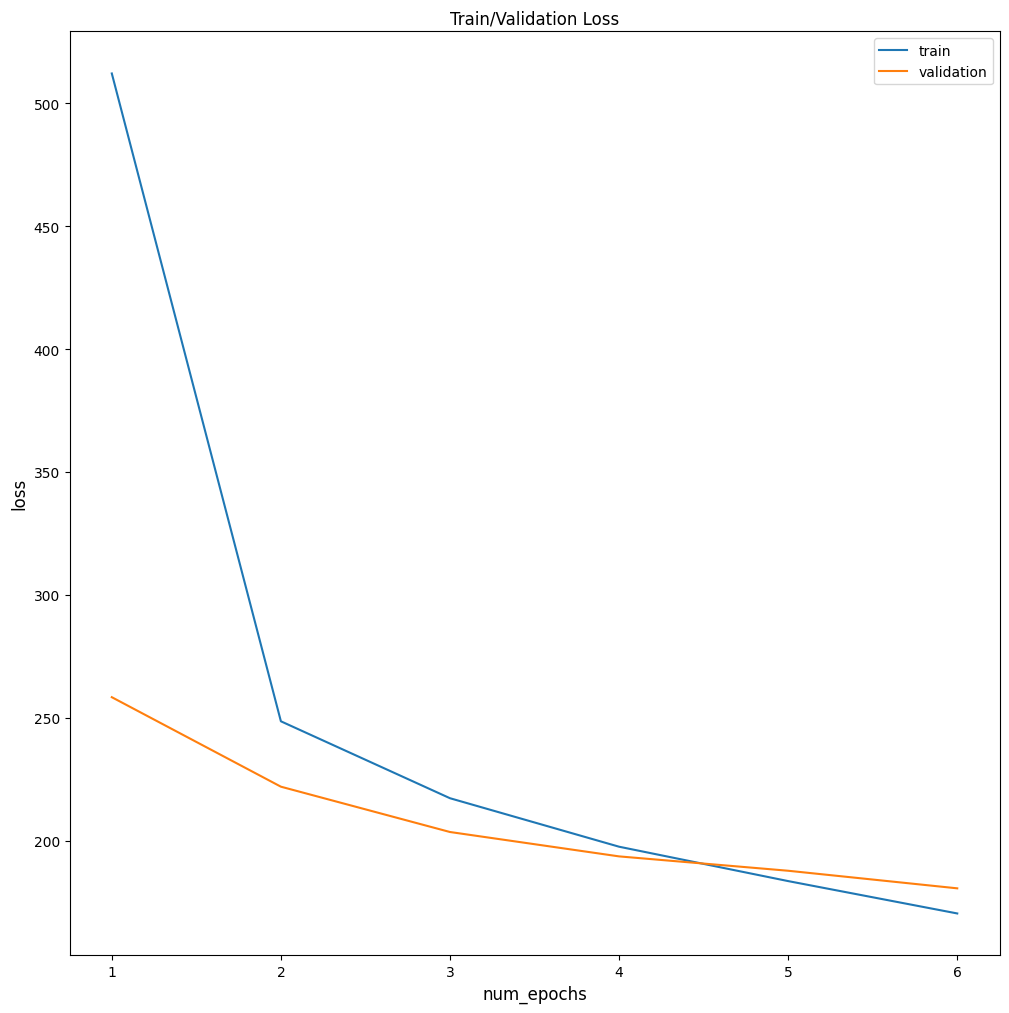

In [37]:
plot_graph(n_epochs)

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

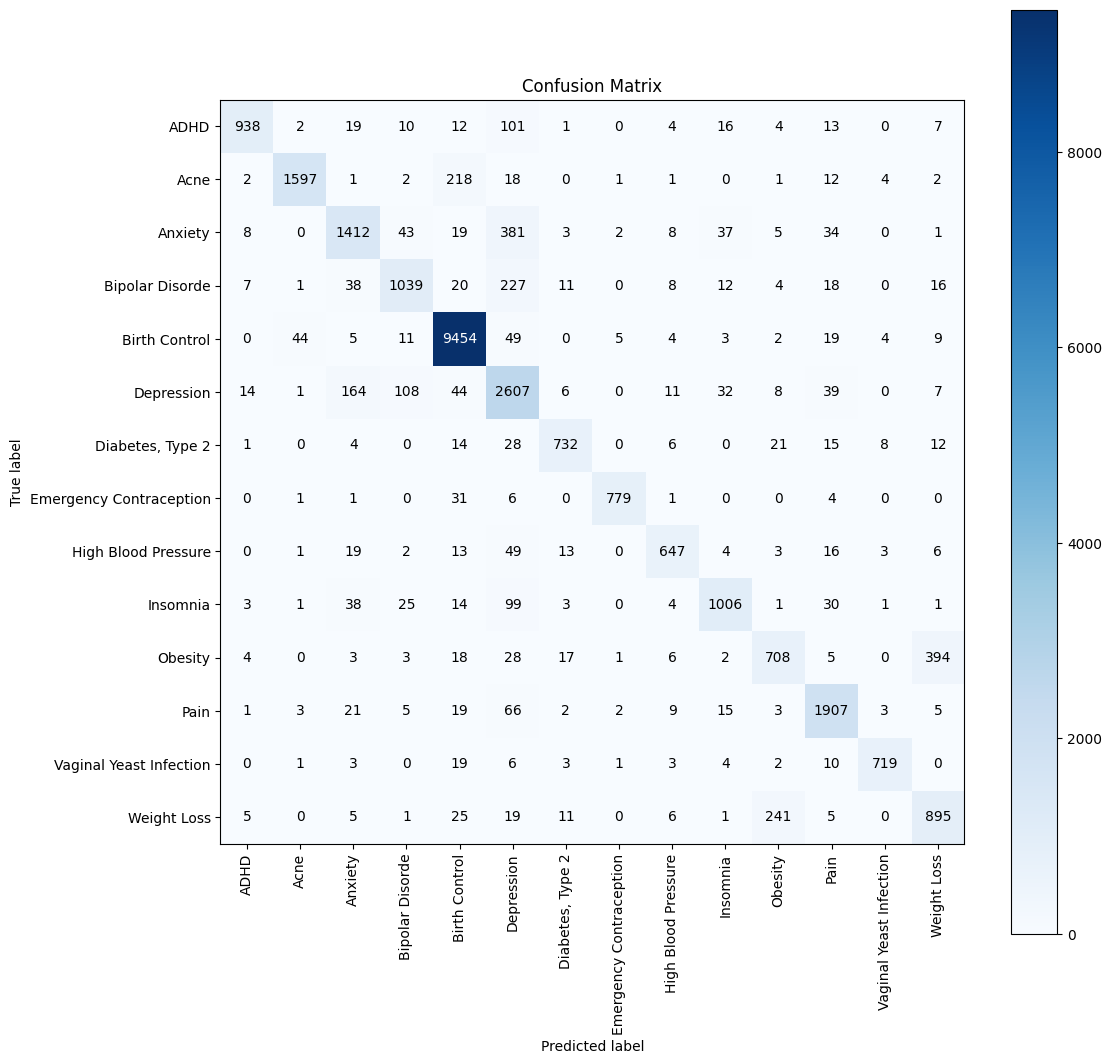

In [40]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true,
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

Pytorch Model - BiLSTM

In [41]:
class BiLSTM(nn.Module):

    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        h_embedding = self.embedding(x)
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [42]:
n_epochs = 6
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)

    # Set model to validation configuration -Doesn't get trained here
    model.eval()
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()

    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<ipython-input-42-a736841218d6>:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/6 	 loss=854.2999 	 val_loss=493.0304  	 val_acc=0.6360  	 time=34.93s
Epoch 2/6 	 loss=380.8621 	 val_loss=272.2812  	 val_acc=0.8276  	 time=33.00s
Epoch 3/6 	 loss=265.3563 	 val_loss=230.4140  	 val_acc=0.8453  	 time=32.85s
Epoch 4/6 	 loss=227.2097 	 val_loss=210.2035  	 val_acc=0.8579  	 time=33.15s
Epoch 5/6 	 loss=207.1853 	 val_loss=202.4388  	 val_acc=0.8621  	 time=32.84s
Epoch 6/6 	 loss=192.8074 	 val_loss=204.1279  	 val_acc=0.8595  	 time=32.86s


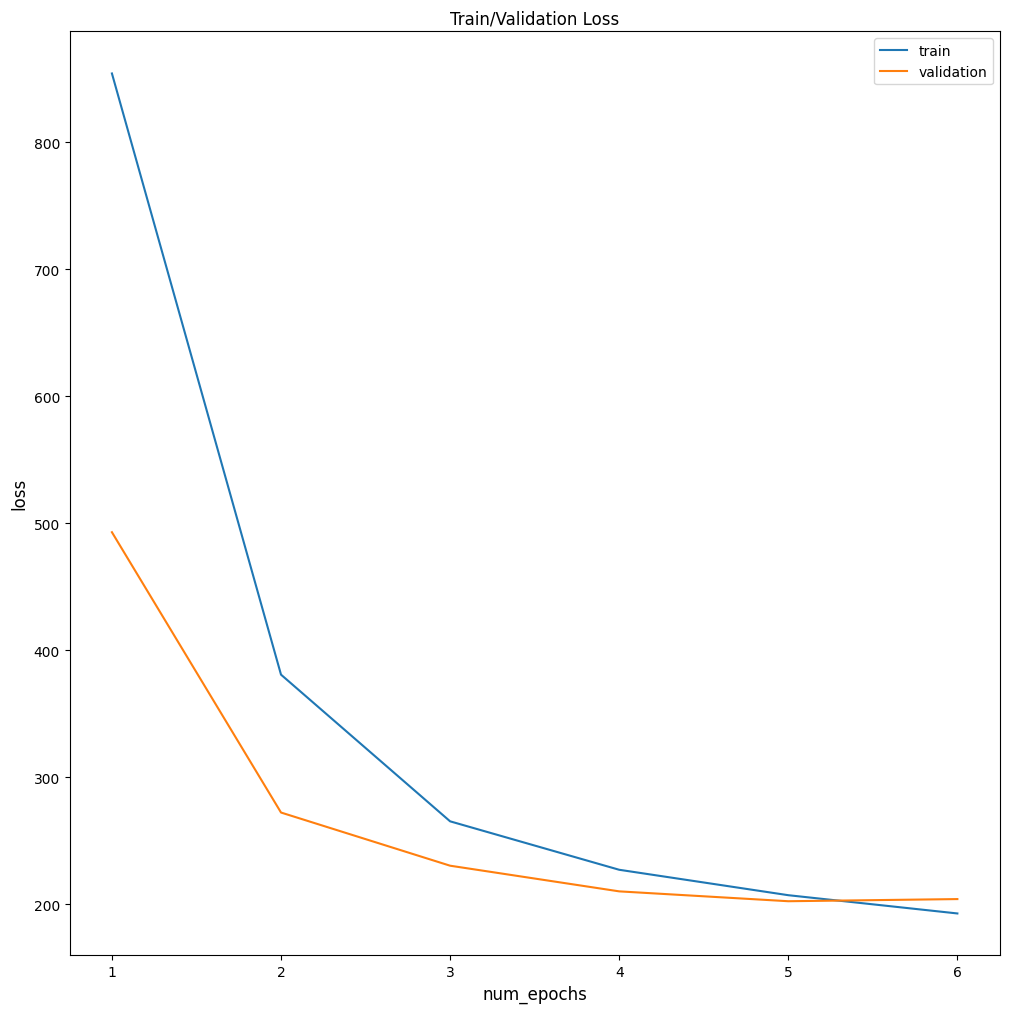

In [43]:
plot_graph(n_epochs)

In [44]:
torch.save(model,'bilstm_model')

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

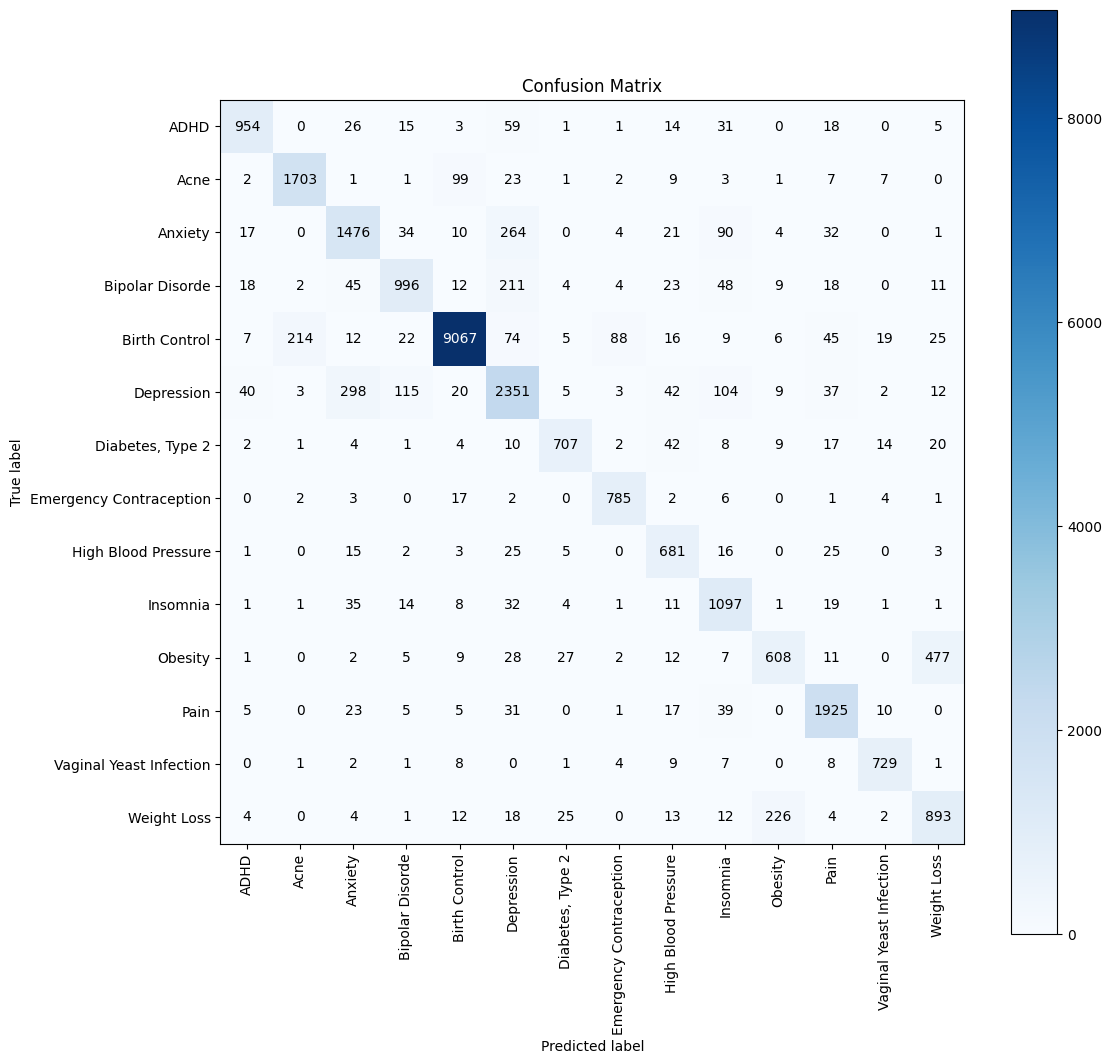

In [45]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true,
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

Deploy : Predict A Single Example

In [59]:
def predict_single(x):
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred, dim=1).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [60]:
x = data['review'].values[0]
print(x)

predict_single(x)

"""my son is halfway through his fourth week of intuniv. we became concerned when he began this last week, when he started taking the highest dose he will be on. for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) i called his doctor on monday morning and she said to stick it out a few days. see how he did at school, and with getting up in the morning. the last two days have been problem free. he is much more agreeable than ever. he is less emotional (a good thing), less cranky. he is remembering all the things he should. overall his behavior is better. 


'ADHD'

In [61]:
# try the cnntext
def predict_single(x):
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    model = torch.load('textcnn_model')
    pred = model(x).detach()
    pred = F.softmax(pred, dim=1).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [62]:
x = data['review'].values[0]
print(x)

predict_single(x)

"""my son is halfway through his fourth week of intuniv. we became concerned when he began this last week, when he started taking the highest dose he will be on. for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) i called his doctor on monday morning and she said to stick it out a few days. see how he did at school, and with getting up in the morning. the last two days have been problem free. he is much more agreeable than ever. he is less emotional (a good thing), less cranky. he is remembering all the things he should. overall his behavior is better. 


'ADHD'

In [63]:
# try the bilstm
def predict_single(x):
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    model = torch.load('bilstm_model')
    pred = model(x).detach()
    pred = F.softmax(pred, dim=1).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [64]:
x = data['review'].values[0]
print(x)

predict_single(x)

"""my son is halfway through his fourth week of intuniv. we became concerned when he began this last week, when he started taking the highest dose he will be on. for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) i called his doctor on monday morning and she said to stick it out a few days. see how he did at school, and with getting up in the morning. the last two days have been problem free. he is much more agreeable than ever. he is less emotional (a good thing), less cranky. he is remembering all the things he should. overall his behavior is better. 


'ADHD'

In [70]:
import pandas as pd

# Load the test dataset
test_data = pd.read_csv('/content/drive/MyDrive/research/drugsComTest_raw.tsv', sep='\t')

def predict_reviews(test_data, num_reviews=20):
    for i in range(num_reviews):
        # Get review text
        review_text = test_data['review'].iloc[i]

        # Predict condition
        predicted_condition = predict_single(review_text)

        # Actual condition from dataset
        actual_condition = test_data['condition'].iloc[i]

        # Display results
        print("Review Text:", review_text)
        print("Predicted Condition:", predicted_condition)
        print("Actual Condition:", actual_condition)
        print()

# Predict conditions for 20 reviews
predict_reviews(test_data, num_reviews=20)

Review Text: "I&#039;ve tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I&#039;ve actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me."
Predicted Condition: Depression
Actual Condition: Depression

Review Text: "My son has Crohn&#039;s disease and has done very well on the Asacol.  He has no complaints and shows no side effects.  He has taken as many as nine tablets per day at one time.  I&#039;ve been very happy with the results, reducing his bouts of diarrhea drastically."
Predicted Condition: High Blood Pressure
Actual Condition: Crohn's Disease, Maintenance

Review Text: "Quick reduction of symptoms"
Predicted Condition: Pain
Actual Condition: Urinary Tract Infection

Re